<h1><bold>
<hr style="border-width:2px;border-color:#1664c8">
Partie <b>6</b><br>
<center>Traduction Seq2Seq<br>
des fichiers <b>"small_vocab_en"</b> et <b>"small_vocab_fr"</b><br></center> 
<div style="text-align: right;">Version 2</div><br>
<hr style="border-width:2px;border-color:#1664c8">
</h1></bold>

### **Dans ce notebook, nous effectuons la traduction d'un langue Source vers une langue Cible**  
> Il suffit de modifier les variables 'src' et 'tgt' ci-dessous pour changer le sens de la traduction (langues possibles: en et fr)

### **1. Préparation des corpus source et cible dans text_pairs**
> Dans le corpus cible, on ajoute les tokens "[start]" et "[end]"

In [1]:
import os
import time

def load_data(path):

    # Nombre maximum de lignes à renvoyer
    max_lines = 140000
    
    input_file = os.path.join(path)
    with open(input_file, "r",  encoding="utf-8") as f:
        data = f.read()
        
    # On convertit les majuscules en minulcule
    data = data.lower()
    
    data = data.split('\n')
    return data[:min(len(data),max_lines)]

# Indication de calculer le score Bleu
bleu_score_to_do = True

# Chargement des textes dans les 2 langues (max lignes = max_lines)
src = 'en'
tgt = 'fr'
txt_tgt = load_data('../data/small_vocab_'+tgt)
txt_src = load_data('../data/small_vocab_'+src)

text_pairs = []
text_tgt_to_vec = []
text_pairs_to_vec = []
for line in range(len(txt_src)):
    text_pairs.append((txt_src[line], "[start] " + txt_tgt[line] + " [end]" ))
    text_tgt_to_vec.append(txt_tgt[line])
    

**Initialisation de corpus 'train' (70% des phrases), 'validation' (15%) et 'test' (15%)**
> et melange de ces ensembles

In [2]:
# Mélange des paires de phrases
import random
random.Random(4).shuffle(text_pairs)
random.Random(4).shuffle(text_tgt_to_vec)
print(text_pairs[0])

# Definition de la taille des corpus
num_val_samples = int(0.15 * len(text_pairs)) # 15%
num_train_samples = len(text_pairs) - 2 * num_val_samples  # 70%

train_pairs = text_pairs[:num_train_samples]
train_tgt_to_vec = text_tgt_to_vec[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

('california is usually busy during december , but it is dry in march .', '[start] californie est généralement occupé en décembre , mais il est sec en mars . [end]')


**Vectorisation des paires de texte anglaises et française**  
**Definition de sauvegarde et chargement du vocabulaire pour une utilisation ultérieure**

In [3]:
import tensorflow as tf
import string
import re
from tensorflow import keras
from tensorflow.keras import layers

strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

# Fonction de préprocessing qui convertit le corpus en minuscule et enlève ou remplace certains caractères génants
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    lowercase=tf.strings.regex_replace(lowercase, "[à]", "a")
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# Les 2 fonctions ci-dessous permeetent de sauvegarder et charger le vocabulaire pour une utilisation ultérieure
def save_vocab(file_path, vocab):
    with open(file_path, "w",  encoding="utf-8" ) as file:
        for word in vocab:
            file.write(word+'\n')
    return

def load_vocab(file_path):
    with open(file_path, "r",  encoding="utf-8") as file:
        return file.read().split('\n')[:-1]


vocab_size = 15000
sequence_length = 30

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    # Si les fichier vocab n'existe pas, mette en commentaire la ligne ci-dessous qui précise le vocabulaire
    vocabulary = load_vocab("../data/vocab_"+src+".txt"),
    standardize=custom_standardization,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    # Si les fichier vocab n'existe pas, mette en commentaire la ligne ci-dessous qui précise le vocabulaire
    vocabulary = load_vocab("../data/vocab_"+tgt+".txt"),
    standardize=custom_standardization,
)
train_src_texts = [pair[0] for pair in train_pairs]
train_tgt_texts = [pair[1] for pair in train_pairs]

**Si les fichier vocab existe déjà, IL NE FAUT PAS EXECUTER le code ci-dessous.  
Sinon il faut l'executer, et ainsi sauvegarder le vocabulaire**

In [4]:
#buff = train_src_texts[0]
#train_tgt_to_vec[0] = "[start] [end] "+train_tgt_to_vec[0]
#train_src_texts[0] = "[start] [end] "+ train_src_texts[0]
#source_vectorization.adapt(train_src_texts)
#target_vectorization.adapt(train_tgt_to_vec)
#train_src_texts[0] = buff
#save_vocab("../data/vocab_"+tgt+".txt" , target_vectorization.get_vocabulary()[2:])
#save_vocab("../data/vocab_"+src+".txt" , source_vectorization.get_vocabulary()[2:])

**Preparation des datasets 'train' et 'val' pour la tache de traduction**
> Nou transformons nos données en un pipeline tf.data.  
> Nous voulons qu'il renvoie un **tuple (inputs, target)** où inputs est un dict avec deux clés, **"encoder_inputs"** (la phrase source) et **"decoder_inputs"** (la phrase target), et **target** est la phrase target décalée d'un pas en avant.  
> La taille des batchs = 64

In [5]:
batch_size = 64

def format_dataset(source, target):
    source = source_vectorization(source)
    target = target_vectorization(target)
    return ({
        src: source,
        tgt: target[:, :-1],
    }, target[:, 1:])

def make_dataset(pairs):
    src_texts, tgt_texts = zip(*pairs)
    tgt_texts = list(tgt_texts)
    src_texts = list(src_texts)
    dataset = tf.data.Dataset.from_tensor_slices((src_texts, tgt_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

**Affichage des dimensions du tuple**

In [6]:
for inputs, targets in train_ds.take(1):
    print(f"inputs[tgt].shape: {inputs[tgt].shape}")
    print(f"inputs[src].shape: {inputs[src].shape}")
    print(f"targets.shape: {targets.shape}")

inputs[tgt].shape: (64, 30)
inputs[src].shape: (64, 30)
targets.shape: (64, 30)


### **2. Mise en oeuvre d'une traduction Seq2Seq avec 2 RNN (GRU)**

**Definition d'un Encoder GRU**

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

embed_dim = 256
latent_dim = 1024

source = keras.Input(shape=(None,), dtype="int64", name=src)
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
encoded_source = layers.Bidirectional(
    layers.GRU(latent_dim), merge_mode="sum")(x)

**Définition du décoder GRU et du modèle complet (encoder, décoder)**

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 en (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 fr (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 256)    3840000     ['en[0][0]']                     
                                                                                                  
 embedding_1 (Embedding)        (None, None, 256)    3840000     ['fr[0][0]']                     
                                                                                              

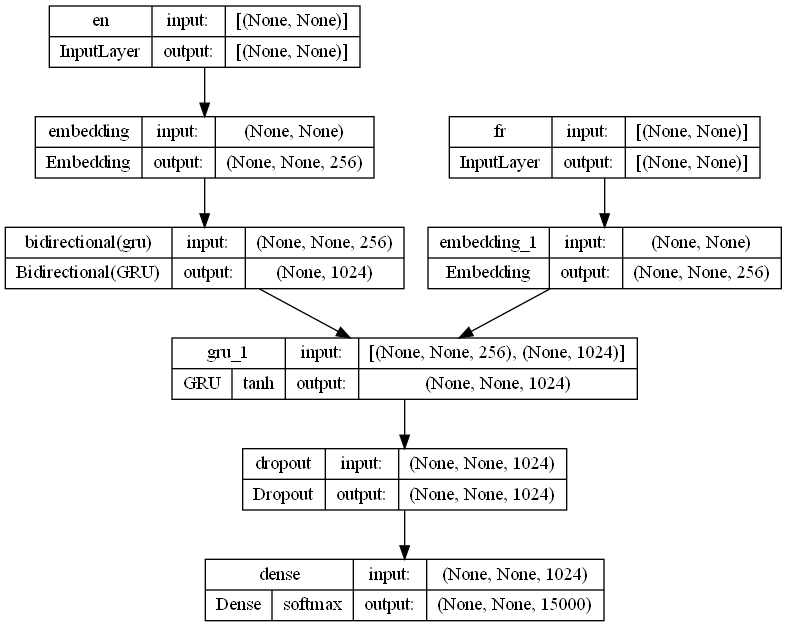

In [8]:
from PIL import Image
from tensorflow.keras.utils import plot_model

past_target = keras.Input(shape=(None,), dtype="int64", name=tgt)
x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(past_target)
decoder_gru = layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state=encoded_source)
x = layers.Dropout(0.5)(x)
target_next_step = layers.Dense(vocab_size, activation="softmax")(x)

seq2seq_rnn = keras.Model([source, past_target], target_next_step)
seq2seq_rnn.summary()

# plot_model(seq2seq_rnn, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')


**Compilation et entrainement du modèle RNN**

In [9]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
seq2seq_rnn.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Epoch 1/50
1508/1508 [==============================] - 131s 75ms/step - loss: 0.2943 - accuracy: 0.8193 - val_loss: 0.0353 - val_accuracy: 0.9778
Epoch 2/50
1508/1508 [==============================] - 109s 72ms/step - loss: 0.0310 - accuracy: 0.9815 - val_loss: 0.0185 - val_accuracy: 0.9887
Epoch 3/50
1508/1508 [==============================] - 109s 72ms/step - loss: 0.0205 - accuracy: 0.9877 - val_loss: 0.0144 - val_accuracy: 0.9914
Epoch 4/50
1508/1508 [==============================] - 109s 73ms/step - loss: 0.0161 - accuracy: 0.9905 - val_loss: 0.0123 - val_accuracy: 0.9928
Epoch 5/50
1508/1508 [==============================] - 109s 72ms/step - loss: 0.0135 - accuracy: 0.9919 - val_loss: 0.0114 - val_accuracy: 0.9934
Epoch 6/50
1508/1508 [==============================] - 109s 72ms/step - loss: 0.0120 - accuracy: 0.9928 - val_loss: 0.0107 - val_accuracy: 0.9941
Epoch 7/50
1508/1508 [==============================] - 107s 71ms/step - loss: 0.0110 - accuracy: 0.9934 - val_loss: 0

**Sauvegarde du model RNN entrainé**

In [7]:
# Attention les instructions suivantes (en commentaire) génèrent un fichier de taille > 100 Mo, ce qui bloque la synchronisation avec Github (commit)
#seq2seq_rnn.save("../data/seq2seq_rnn-model-"+src+"-"+tgt+".h5")
#seq2seq_rnn.save("../data/seq2seq_rnn-model_no_opt-"+src+"-"+tgt+".h5", include_optimizer=False)
#seq2seq_rnn.save_weights("../data/seq2seq_rnn-model-"+src+"-"+tgt+".weights.h5")

# Voici une instruction qui permet de passer sous la barre des 100 Mo.....
#from filesplit.split import Split
#Split("../data/seq2seq_rnn-model-"+src+"-"+tgt+".h5", "../data/rnn_"+src+"-"+tgt+"_split").bysize(66846720)

#seq2seq_rnn = keras.models.load_model("../data/seq2seq_rnn-model-"+src+"-"+tgt+".h5")

**Traduction de nouvelles phrases avec le modèle RNN**

In [10]:
import numpy as np
tgt_vocab = target_vectorization.get_vocabulary()
tgt_index_lookup = dict(zip(range(len(tgt_vocab)), tgt_vocab))
max_decoded_sentence_length = 30

def decode_sequence_rnn(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])
        next_token_predictions = seq2seq_rnn.predict(
            [tokenized_input_sentence, tokenized_target_sentence], verbose=0)
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])
        sampled_token = tgt_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-6]

test_src_texts = [pair[0] for pair in test_pairs]
for _ in range(20):
    input_sentence = random.choice(test_src_texts)
    print("-")
    print(src.upper()+"  ",input_sentence)
    print(tgt.upper()+"->",decode_sequence_rnn(input_sentence))

-
EN   she drives that little green truck .
FR-> elle conduit ce petit camion vert
-
EN   california is usually chilly during fall , and it is sometimes pleasant in spring .
FR-> californie est généralement froid a lautomne et il est parfois agréable au printemps
-
EN   she likes limes and apples .
FR-> elle aime citrons verts et des pommes
-
EN   france is usually beautiful during october , and it is quiet in november .
FR-> la france est généralement beau en octobre et il est calme en novembre
-
EN   your most loved animals were elephants .
FR-> vos animaux les plus aimés étaient des éléphants
-
EN   china is sometimes pleasant during autumn , but it is sometimes nice in august .
FR-> la chine est parfois agréable au cours de l automne mais il est parfois agréable en août
-
EN   california is pleasant during january , but it is busy in may .
FR-> californie est agréable en janvier mais il est occupé en mai
-
EN   california is never quiet during spring , but it is usually nice in may

In [11]:
if src=='fr':
    your_sentence1 = "paris est pluvieux pendant l'été, mais la france n'est jamais magnifique en hiver" 
    your_sentence2 = "new jersey est parfois calme pendant l' automne , et il est neigeux en avril ." 
else:
    your_sentence1 = "paris is rainy during summer , and france is never wonderful in winter"
    your_sentence2 = "new jersey is sometimes quiet during autumn , and it is snowy in april ."
    
print(tgt.upper()+"->",decode_sequence_rnn(your_sentence1))
print(tgt.upper()+"->",decode_sequence_rnn(your_sentence2))

FR-> paris est pluvieux pendant l été et il est jamais merveilleux en hiver
FR-> new jersey est parfois calme pendant l automne et il est neigeux en avril


### **3. Mise en boeuvre de la traduction avec un Transformer**

**Définition du décoder Transformer**

In [14]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = mask
        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

**Definition de la couche PositionalEmbedding**

In [15]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

**Definition du modèle Transformer complet**

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 en (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 fr (InputLayer)                [(None, None)]       0           []                               
                                                                                                  
 positionalEmbeddingSource (Pos  (None, None, 256)   3847680     ['en[0][0]']                     
 itionalEmbedding)                                                                                
                                                                                                  
 positionalEmbeddingTarget (Pos  (None, None, 256)   3847680     ['fr[0][0]']               

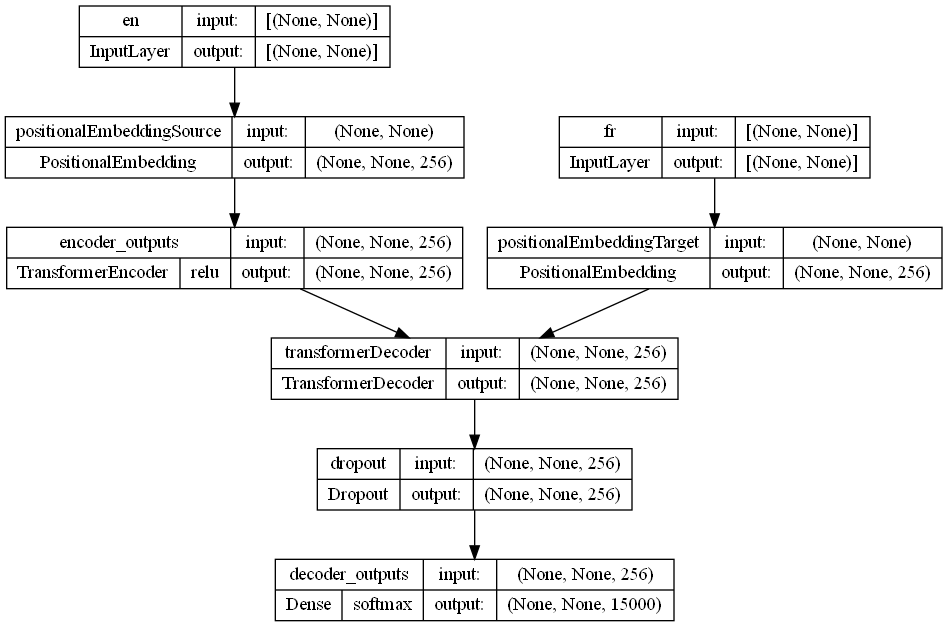

In [17]:
from keras_nlp.layers import TransformerEncoder
from PIL import Image
from tensorflow.keras.utils import plot_model

embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name=src)
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, name='positionalEmbeddingSource')(encoder_inputs)
encoder_outputs = TransformerEncoder(dense_dim, num_heads, name='encoder_outputs')(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name=tgt)
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim, name='positionalEmbeddingTarget')(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads,  name='transformerDecoder')(x, encoder_outputs)
x = layers.Dropout(0.5, name='dropout')(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax", name='decoder_outputs')(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)
transformer.summary()

plot_model(transformer, show_shapes=True, show_layer_names=True, show_layer_activations=True,rankdir='TB')

**Compilation et entrainement du modèle**

In [18]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
transformer.fit(train_ds, epochs=50, validation_data=val_ds, callbacks=[stop_early])

Epoch 1/50
1508/1508 [==============================] - 94s 60ms/step - loss: 0.1602 - accuracy: 0.9205 - val_loss: 0.0351 - val_accuracy: 0.9768
Epoch 2/50
1508/1508 [==============================] - 91s 60ms/step - loss: 0.0368 - accuracy: 0.9779 - val_loss: 0.0270 - val_accuracy: 0.9830
Epoch 3/50
1508/1508 [==============================] - 91s 60ms/step - loss: 0.0288 - accuracy: 0.9830 - val_loss: 0.0227 - val_accuracy: 0.9858
Epoch 4/50
1508/1508 [==============================] - 91s 60ms/step - loss: 0.0248 - accuracy: 0.9854 - val_loss: 0.0198 - val_accuracy: 0.9879
Epoch 5/50
1508/1508 [==============================] - 92s 61ms/step - loss: 0.0217 - accuracy: 0.9872 - val_loss: 0.0188 - val_accuracy: 0.9886
Epoch 6/50
1508/1508 [==============================] - 94s 62ms/step - loss: 0.0193 - accuracy: 0.9886 - val_loss: 0.0181 - val_accuracy: 0.9888
Epoch 7/50
1508/1508 [==============================] - 92s 61ms/step - loss: 0.0171 - accuracy: 0.9900 - val_loss: 0.0157 -

**Sauvegarde/Chargement du model Transformer entrainé**

In [12]:
### Sauvegarde du modèle entrainé
#for i in range(len(transformer.weights)):
#    transformer.weights[i]._handle_name = transformer.weights[i].name + "_" + str(i)
    
#transformer.save("../data/transformer-model-"+src+"-"+tgt+".h5", include_optimizer=False)
#transformer.save_weights("../data/transformer-model-"+src+"-"+tgt+".weights.h5")

### Chargement d'un modèle pré-entrainé

#from keras_nlp.layers import TransformerEncoder
#transformer = keras.models.load_model(
#    "../data/transformer-model-"+src+"-"+tgt+".h5",
#    custom_objects={"PositionalEmbedding": PositionalEmbedding, "TransformerDecoder": TransformerDecoder},
#)
#transformer.load_weights("../data/transformer-model-"+src+"-"+tgt+".weights.h5")

transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

**Traduction de nouvelles phrases avec le modèle Transformer**

In [21]:
import numpy as np
tgt_vocab = target_vectorization.get_vocabulary()
tgt_index_lookup = dict(zip(range(len(tgt_vocab)), tgt_vocab))
max_decoded_sentence_length = 30

def decode_sequence_transf(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = tgt_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence[8:-6]

test_src_texts = [pair[0] for pair in test_pairs]
test_tgt_texts = [pair[1][8:-6] for pair in test_pairs]

# Removing Punctuations (we keep the . character)
REPLACEMENTS = [(".", ""),
                (",", ""),
                (";", ""),
                (":", ""),
                ("?", ""),
                ('"', ""),
                ("-", " "),
                ("'", " ")
               ]
for i in range(len(test_tgt_texts)):
    for old, new in REPLACEMENTS:
        test_tgt_texts[i] = test_tgt_texts[i].replace(old, new)
        
for _ in range(20):
    n = random.randrange(num_val_samples)
    input_sentence = test_src_texts[n]
    translation = test_tgt_texts[n]
    print("-")
    print(src.upper()+" ",input_sentence)
    print(tgt.upper()+"  ",translation)
    print(tgt.upper()+"->",decode_sequence_transf(input_sentence))

-
EN  why are they going to the united states ?
FR   pourquoi ils vont aux états unis 
FR-> pourquoi ils vont aux étatsunis
-
EN  new jersey is beautiful during july , but it is never freezing in november .
FR   new jersey est belle en juillet  mais il gèle jamais en novembre 
FR-> new jersey est belle en juillet mais il gèle jamais en novembre
-
EN  china is sometimes pleasant during march , but it is busy in may .
FR   la chine est parfois agréable au mois de mars  mais il est occupé en mai 
FR-> la chine est parfois agréable au mois de mars mais il est occupé en mai
-
EN  he drove the little green automobile .
FR   il a conduit la petite voiture verte 
FR-> il a conduit la petite voiture verte
-
EN  he likes bananas , strawberries , and grapefruit .
FR   il aime les bananes  les fraises et le pamplemousse 
FR-> il aime les bananes les fraises et le pamplemousse
-
EN  the grapefruit is their favorite fruit , but the lime is her favorite .
FR   le pamplemousse est leur fruit préféré  

### **4. Utilisation de nos traducteurs Seq2Seq et verification de leur qualité**

<br></br>
**A votre tour d'éssayer**  
Saisissez un phrase..

In [18]:
if src=='fr':
    your_sentence1 = "paris est pluvieux pendant l'été, mais la france n'est jamais magnifique en hiver" 
    your_sentence2 = "new jersey est parfois calme pendant l' automne , et il est neigeux en avril ." 
else:
    your_sentence1 = "paris is rainy during summer , and france is never wonderful in winter"
    your_sentence2 = "new jersey is sometimes quiet during autumn , and it is snowy in april ."
    

print(tgt.upper()+"->",decode_sequence_transf(your_sentence1))
print(tgt.upper()+"->",decode_sequence_transf(your_sentence2))

FR-> paris est pluvieux pendant l été et il est merveilleux jamais en hiver
FR-> new jersey est parfois calme pendant l automne et il est neigeux en avril


**Qualité de traduction Seq2Seq sur le corpus Test par les 2 méthodes (300 premieres phrases)**

In [19]:
from sacrebleu import sentence_bleu, corpus_bleu

# Taille du corpus d'évaluation
n = 300

def corpus_translation(method):
    translation = []
    test_src_texts = [pair[0] for pair in test_pairs]
    for txt in test_src_texts[:n]:
        if method == 'RNN':
            translation.append(decode_sequence_rnn(txt))
        else:
            translation.append(decode_sequence_transf(txt))
    return translation

if bleu_score_to_do:
    tps1 = time.time()
    tr_RNN = corpus_translation('RNN')
    translation_quality_RNN = corpus_bleu(tr_RNN, [test_tgt_texts[:n]]).score
    print(f'Score Bleu de la traduction du corpus Test par la méthode RNN = {translation_quality_RNN:.1f}%')
    tps2 = time.time()
    print(" -> durée de traduction et de calcul du score :",int(tps2-tps1)," secondes\n")
    tr_Transformer = corpus_translation('Transformer')
    translation_quality_Transformer = corpus_bleu(tr_Transformer, [test_tgt_texts[:n]]).score
    print(f'Score Bleu de la traduction du corpus Test par la méthode Transformer = {translation_quality_Transformer:.1f}%')
    tps3 = time.time()
    print(" -> durée de traduction et de calcul du score :",int(tps3-tps2)," secondes\n")


Score Bleu de la traduction du corpus Test par la méthode RNN = 91.4%
 -> durée de traduction et de calcul du score : 338  secondes

Score Bleu de la traduction du corpus Test par la méthode Transformer = 91.9%
 -> durée de traduction et de calcul du score : 144  secondes

